# Task 6: Time Series Classification (Similarity-Based)

This notebook implements **Task 6: Time Series Classification** using **time series only as input**, with **labels taken from the tabular dataset**.

We follow the course recommendations from:
- `5-data-understanding_ts.pdf` (preprocessing, stationarity, TS statistics)
- `8_time_series_similarity_2024.pdf` (preprocessing, approximation, similarity measures like Euclidean and DTW)

We will:
1. Define the patient cohort using `patient_profile_small.csv` (same labels as the tabular binary classification task).
2. Build univariate laboratory time series per patient (as in `3.1_timeseries_alex_executed.ipynb`).
3. Apply slide-based preprocessing (offset removal, scaling, optional trend and noise filtering).
4. Compute similarities (Euclidean and especially DTW) between time series.
5. Train a k-NN classifier on these similarities to predict the binary label.

Only time series will be used as input features for the *core* classifier; tabular data are used only to obtain labels (and possibly for an optional fusion experiment later).

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style (same as in 3.1_timeseries_alex_executed.ipynb)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set paths - align with previous notebooks
base_path = Path.cwd()
if base_path.name == 'code':
    base_path = base_path.parent

data_path = base_path / 'Data'
code_path = base_path / 'code'

print(f"Working directory: {base_path}")
print(f"Data path: {data_path}")

Working directory: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi
Data path: /Users/alexandermittet/Library/Mobile Documents/com~apple~CloudDocs/uni_life/UniPi DAD/data_analytics_4_health_unipi/Data


## Task 6 Specifications

**Requirements:**
- Use **pre-processed time series** as input
- Limit analysis to patients with **corresponding tabular data** (merge on patient id)
- Use **same labels** as the binary classification task from the tabular dataset
- **Only time series** should be used as input for the classification model
- **Tabular data** serves **only to obtain labels** (not as input features)

**Approach:**
- Labels: `is_dead` from `patient_profile_small.csv` (same as tabular classification)
- Input: Preprocessed univariate laboratory time series only
- Method: Similarity-based classification (Euclidean and DTW distances with k-NN)

## 1. Define Data for Time Series Classification

**Following Task 6 specifications:** We use **the same labels** as in the tabular binary classification task (`patient_profile_small.csv`), but **only time series are used as input** for the classification model. Tabular data serve **only to obtain labels**.

- Load patient-level labels from `Data/patient_profile_small.csv` (same source as tabular classification)
- Merge laboratory time series data with labeled patients on `subject_id` / `hadm_id`
- Restrict to patients who have both: (1) a label in the tabular dataset, and (2) a usable laboratory time series

In [40]:
# Load patient-level profile and labels (same source as tabular classification)
patient_profile_path = data_path / 'patient_profile_small.csv'
patient_df = pd.read_csv(patient_profile_path)

print(f"Patient profile shape: {patient_df.shape}")
print("Columns:", patient_df.columns.tolist())

# Quick look at the first rows to recall label structure
patient_df.head()

Patient profile shape: (5166, 16)
Columns: ['subject_id', 'hadm_id', 'clinical_activity', 'hematologic_stability_score', 'history_depth', 'inflammation_liver_stress_index', 'metabolic_stress_index', 'micro_resistance_score', 'oxygenation_dysfunction_index', 'procedure_density', 'renal_injury_score', 'age', 'is_dead', 'gender', 'abnormal_ratio', 'qc_fail_ratio']


,subject_id,hadm_id,clinical_activity,hematologic_stability_score,history_depth,inflammation_liver_stress_index,metabolic_stress_index,micro_resistance_score,oxygenation_dysfunction_index,procedure_density,renal_injury_score,age,is_dead,gender,abnormal_ratio,qc_fail_ratio
0,10000980,26913865,2.375005,-1.580146,6.965080,-0.680743,0.948936,0.0,-0.145857,7.000000,1.915404,75.0,1.0,F,0.0,0.024096
1,10000980,29654838,1.370160,-1.009657,6.647688,-1.206081,0.482979,0.0,0.708820,0.000000,1.188131,75.0,1.0,F,0.0,0.000000
2,10002013,24760295,1.659969,0.514990,7.604894,0.000000,2.817021,0.0,0.715771,2.000000,-2.017677,NaN,0.0,F,0.0,0.000000
3,10002155,23822395,3.033730,-0.413521,7.469084,0.000000,-0.095745,0.0,-0.455848,0.571429,2.340909,NaN,0.0,F,0.0,0.030227
4,10004457,28723315,1.161098,1.473653,7.486613,-0.667314,-1.406383,0.0,0.717315,0.000000,-0.506313,66.0,0.0,M,0.0,0.040000


### 1.1 Select binary label from tabular task

We use `is_dead` from `patient_profile_small.csv` as the binary target, as in the tabular classification task, and keep one row per `subject_id`.

In [41]:
label_col = "is_dead"

# Drop rows with missing label
patient_labeled = patient_df.dropna(subset=[label_col]).copy()

# Keep one row per subject_id (first admission)
patient_labeled = (
    patient_labeled
    .sort_values(["subject_id", "hadm_id"])
    .drop_duplicates(subset=["subject_id"], keep="first")
)

print("Patients with label:", patient_labeled.shape[0])
print(patient_labeled[label_col].value_counts())
print(patient_labeled[label_col].value_counts(normalize=True))
patient_labeled.head()

Patients with label: 4392
is_dead
0.0    4039
1.0     353
Name: count, dtype: int64
is_dead
0.0    0.919627
1.0    0.080373
Name: proportion, dtype: float64


,subject_id,hadm_id,clinical_activity,hematologic_stability_score,history_depth,inflammation_liver_stress_index,metabolic_stress_index,micro_resistance_score,oxygenation_dysfunction_index,procedure_density,renal_injury_score,age,is_dead,gender,abnormal_ratio,qc_fail_ratio
0,10000980,26913865,2.375005,-1.580146,6.965080,-0.680743,0.948936,0.0,-0.145857,7.000000,1.915404,75.0,1.0,F,0.0,0.024096
2,10002013,24760295,1.659969,0.514990,7.604894,0.000000,2.817021,0.0,0.715771,2.000000,-2.017677,NaN,0.0,F,0.0,0.000000
3,10002155,23822395,3.033730,-0.413521,7.469084,0.000000,-0.095745,0.0,-0.455848,0.571429,2.340909,NaN,0.0,F,0.0,0.030227
4,10004457,28723315,1.161098,1.473653,7.486613,-0.667314,-1.406383,0.0,0.717315,0.000000,-0.506313,66.0,0.0,M,0.0,0.040000
5,10007058,22954658,2.249905,-1.463186,7.409742,-0.442178,-0.204255,0.0,0.711523,2.000000,-0.392677,48.0,0.0,M,0.0,0.013423


### 1.2 Link time series source (laboratory data) to labeled patients

We use `laboratory_events_codes_2.csv` as time series source and keep only rows for patients present in `patient_profile_small.csv` (merge on `hadm_id` and `subject_id`).

In [42]:
# Load laboratory events (same as in 3.1_timeseries_alex_executed.ipynb)
df_lab = pd.read_csv(data_path / "laboratory_events_codes_2.csv")
df_lab["charttime"] = pd.to_datetime(df_lab["charttime"], errors="coerce")

print("Raw lab rows:", len(df_lab))

# Attach subject_id from patient_profile_small via hadm_id
lab_with_subject = df_lab.merge(
    patient_labeled[["subject_id", "hadm_id"]],
    on="hadm_id",
    how="inner"
)

print("Lab rows with labeled patients:", len(lab_with_subject))
print("Unique subjects with lab and label:", lab_with_subject["subject_id"].nunique())
lab_with_subject[["subject_id", "hadm_id", "charttime", "valuenum", "label"]].head()

Raw lab rows: 978503
Lab rows with labeled patients: 896008
Unique subjects with lab and label: 4384


,subject_id,hadm_id,charttime,valuenum,label
0,10000980,26913865.0,2189-06-28 15:58:00,263.00,Creatine Kinase (CK)
1,10000980,26913865.0,2189-06-28 15:58:00,9.00,"Creatine Kinase, MB Isoenzyme"
2,10000980,26913865.0,2189-06-28 15:58:00,0.11,Troponin T
3,10000980,26913865.0,2189-06-28 23:01:00,9.00,"Creatine Kinase, MB Isoenzyme"
4,10000980,26913865.0,2189-06-28 23:01:00,0.15,Troponin T


## 2. Build Univariate Time Series per Patient

Following the slides (univariate time series) and the previous TS notebook, we focus on one laboratory measurement type (same `label` string) and build one numeric series per `subject_id`.

In [43]:
# Choose one laboratory measurement type (adjust if needed)
measurement_label = "Troponin T"  # example; check availability
print("Available unique lab labels (sample):")
print(lab_with_subject["label"].value_counts().head(20))

# Filter to chosen measurement
ts_df = (
    lab_with_subject
    [lab_with_subject["label"] == measurement_label]
    .dropna(subset=["valuenum", "charttime"])
    .sort_values(["subject_id", "charttime"])
)

print("Rows for chosen measurement:", len(ts_df))
print("Subjects with this measurement:", ts_df["subject_id"].nunique())
ts_df[["subject_id", "charttime", "valuenum"]].head()

Available unique lab labels (sample):
label
Glucose              36273
Potassium            34383
Sodium               33332
Chloride             33253
Creatinine           32624
Urea Nitrogen        32364
Bicarbonate          31682
Anion Gap            31578
Magnesium            30719
Hemoglobin           28389
Hematocrit           28012
Platelet Count       27034
Phosphate            26544
Calcium, Total       26359
White Blood Cells    25975
MCHC                 25927
Red Blood Cells      25923
RDW                  25923
MCV                  25923
MCH                  25923
Name: count, dtype: int64
Rows for chosen measurement: 7167
Subjects with this measurement: 2423


,subject_id,charttime,valuenum
2,10000980,2189-06-28 15:58:00,0.11
4,10000980,2189-06-28 23:01:00,0.15
28,10000980,2189-06-29 09:15:00,0.13
111,10000980,2189-07-01 20:30:00,0.11
123,10000980,2189-07-02 10:20:00,0.15


In [44]:
from collections import defaultdict

min_len = 5  # minimal number of points to keep a time series

patient_series = {}
for sid, group in ts_df.groupby("subject_id"):
    values = group["valuenum"].values.astype(float)
    if len(values) >= min_len:
        patient_series[sid] = values

print("Patients with usable time series:", len(patient_series))
list(patient_series.items())[:1]

Patients with usable time series: 420


[(10000980, array([0.11, 0.15, 0.13, 0.11, 0.15]))]

### 2.1 Visualization: Example Time Series Before Preprocessing

Let's visualize a few example time series in their original form to understand the data we're working with.

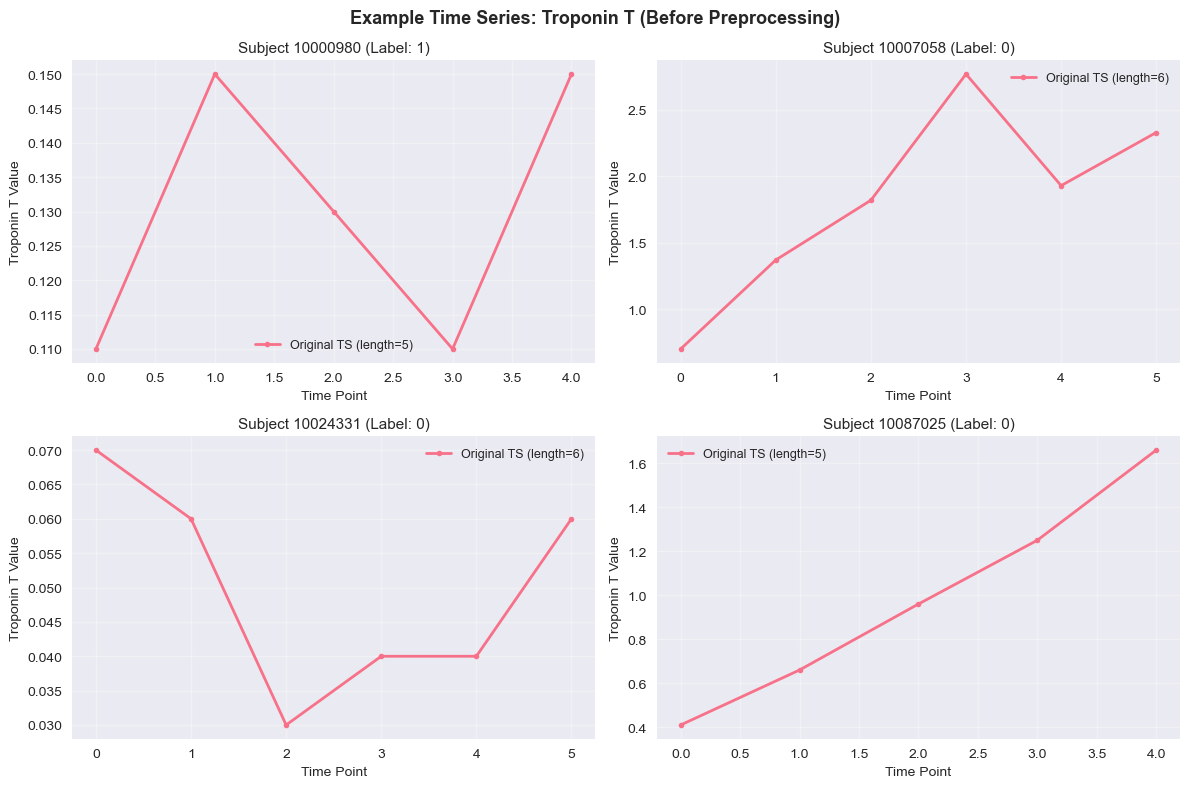

Showing 4 example time series with varying lengths


In [45]:
# Visualize a few example time series (original, before preprocessing)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

example_subjects = list(patient_series.keys())[:4]
for idx, sid in enumerate(example_subjects):
    ax = axes[idx]
    original_ts = patient_series[sid]
    label_val = patient_labeled.set_index("subject_id").loc[sid, label_col]
    
    ax.plot(original_ts, marker='o', linewidth=2, markersize=4)
    ax.set_title(f"Subject {sid} (Label: {int(label_val)})", fontsize=11)
    ax.set_xlabel("Time Point", fontsize=10)
    ax.set_ylabel(f"{measurement_label} Value", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend([f"Original TS (length={len(original_ts)})"], loc='best', fontsize=9)

plt.suptitle(f"Example Time Series: {measurement_label} (Before Preprocessing)", 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Showing {len(example_subjects)} example time series with varying lengths")

## 3. Preprocessing as in Slides (Offset + Amplitude Scaling)

We apply the transformations from the slides:

- **Offset translation removal**: \( Q = Q - \text{mean}(Q) \)
- **Amplitude scaling**: \( Q = (Q - \text{mean}(Q)) / \text{std}(Q) \)

This corresponds to making series comparable in shape, independent of absolute level and scale. These steps are emphasized in `8_time_series_similarity_2024.pdf` (pages on amplitude scaling) and `5-data-understanding_ts.pdf` (preprocessing for stationarity).

In [46]:
def z_normalize(series):
    series = np.asarray(series, dtype=float)
    m = series.mean()
    s = series.std()
    if s == 0:
        return series - m
    return (series - m) / s

patient_series_pre = {
    sid: z_normalize(vals)
    for sid, vals in patient_series.items()
}

# Quick visual check for one patient
example_sid = next(iter(patient_series_pre.keys()))
print("Example subject:", example_sid)
print("Original:", patient_series[example_sid][:10])
print("Preprocessed:", patient_series_pre[example_sid][:10])

Example subject: 10000980
Original: [0.11 0.15 0.13 0.11 0.15]
Preprocessed: [-1.11803399  1.11803399  0.         -1.11803399  1.11803399]


### 3.2 Visualization: Preprocessing Effect (Before vs After)

This visualization demonstrates the effect of preprocessing transformations from the slides: offset removal and amplitude scaling make time series comparable in shape, independent of their absolute values.

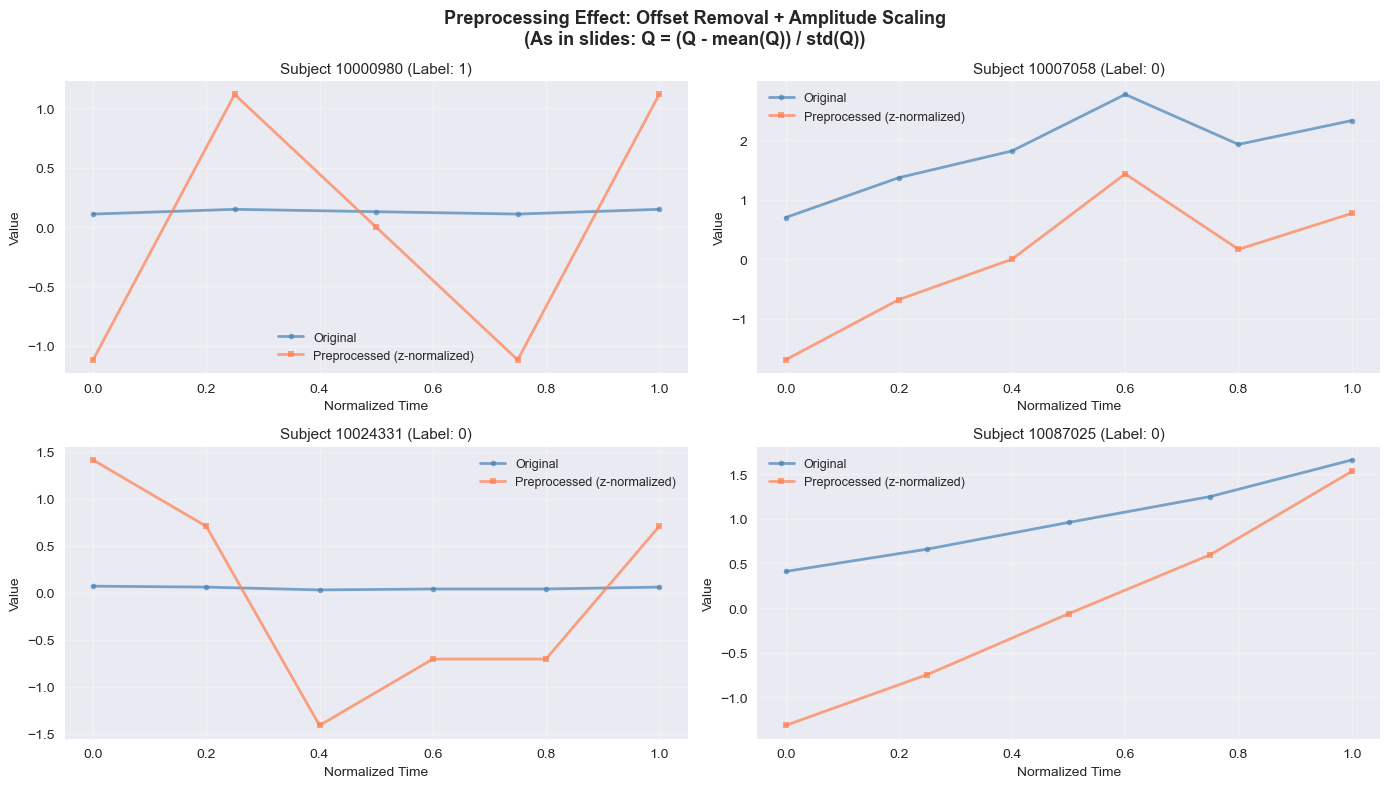

In [47]:
# Compare before and after preprocessing for a few examples
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

example_subjects = list(patient_series.keys())[:4]
for idx, sid in enumerate(example_subjects):
    ax = axes[idx]
    original = patient_series[sid]
    preprocessed = patient_series_pre[sid]
    label_val = patient_labeled.set_index("subject_id").loc[sid, label_col]
    
    # Normalize x-axis for comparison (use relative positions)
    x_orig = np.linspace(0, 1, len(original))
    x_pre = np.linspace(0, 1, len(preprocessed))
    
    ax.plot(x_orig, original, marker='o', linewidth=2, markersize=4, 
            label='Original', alpha=0.7, color='steelblue')
    ax.plot(x_pre, preprocessed, marker='s', linewidth=2, markersize=4, 
            label='Preprocessed (z-normalized)', alpha=0.7, color='coral')
    
    ax.set_title(f"Subject {sid} (Label: {int(label_val)})", fontsize=11)
    ax.set_xlabel("Normalized Time", fontsize=10)
    ax.set_ylabel("Value", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

plt.suptitle("Preprocessing Effect: Offset Removal + Amplitude Scaling\n" + 
             "(As in slides: Q = (Q - mean(Q)) / std(Q))", 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Resample Time Series to Common Length

To use Euclidean distance (and to simplify DTW), we resample each preprocessed series to the same length \(L\) using linear interpolation, as a simple approximation step (similar spirit to approximation methods in the slides, e.g. PAA).

In [48]:
from scipy.interpolate import interp1d

L = 50  # target length (can be tuned)

def resample_to_length(x, L):
    x = np.asarray(x, dtype=float)
    if len(x) == 1:
        return np.repeat(x, L)
    old_idx = np.linspace(0, 1, num=len(x))
    new_idx = np.linspace(0, 1, num=L)
    f = interp1d(old_idx, x, kind="linear")
    return f(new_idx)

patient_seq = {}
for sid, vals in patient_series_pre.items():
    patient_seq[sid] = resample_to_length(vals, L)

print("Patients with resampled series:", len(patient_seq))
list(patient_seq.items())[:1]

Patients with resampled series: 420


[(10000980,
  array([-1.11803399, -0.93549783, -0.75296167, -0.5704255 , -0.38788934,
         -0.20535318, -0.02281702,  0.15971914,  0.3422553 ,  0.52479146,
          0.70732763,  0.88986379,  1.07239995,  1.04958293,  0.95831485,
          0.86704677,  0.77577869,  0.68451061,  0.59324252,  0.50197444,
          0.41070636,  0.31943828,  0.2281702 ,  0.13690212,  0.04563404,
         -0.04563404, -0.13690212, -0.2281702 , -0.31943828, -0.41070636,
         -0.50197444, -0.59324252, -0.68451061, -0.77577869, -0.86704677,
         -0.95831485, -1.04958293, -1.07239995, -0.88986379, -0.70732763,
         -0.52479146, -0.3422553 , -0.15971914,  0.02281702,  0.20535318,
          0.38788934,  0.5704255 ,  0.75296167,  0.93549783,  1.11803399]))]

### 6.1 Hyperparameter Tuning: Grid Search for Optimal k

We perform a grid search to find the optimal number of neighbors (k) that maximizes the F1 score. This helps address the class imbalance issue and improves classification performance.

In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# First, let's diagnose the problem - check class distribution
print("Class distribution in training set:")
print(f"  Class 0 (Alive): {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.1f}%)")
print(f"  Class 1 (Dead): {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.1f}%)")
print(f"\nClass distribution in validation set:")
print(f"  Class 0 (Alive): {np.sum(y_val == 0)} ({np.mean(y_val == 0)*100:.1f}%)")
print(f"  Class 1 (Dead): {np.sum(y_val == 1)} ({np.mean(y_val == 1)*100:.1f}%)")

# Define parameter grid for n_neighbors
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 15, 20, 25, 30]
}

# Create F1 scorer (macro-averaged F1 to account for class imbalance)
f1_scorer = make_scorer(f1_score, average='macro')

# Initialize base classifier with weighted voting to handle class imbalance
# Use 'distance' weights so closer neighbors have more influence
knn_base = KNeighborsClassifier(metric="euclidean", weights='distance')

# Perform grid search with cross-validation
print("\nPerforming grid search for optimal n_neighbors (optimizing F1 score)...")
print("Using distance-weighted voting to handle class imbalance...")
grid_search = GridSearchCV(
    knn_base,
    param_grid,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Get the best model
global knn_euc_best 
knn_euc_best = grid_search.best_estimator_

# Evaluate on validation set
y_pred_euc = knn_euc_best.predict(X_val)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"\nValidation set accuracy: {accuracy_score(y_val, y_pred_euc):.4f}")
print(f"Validation set F1 score (macro): {f1_score(y_val, y_pred_euc, average='macro'):.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_pred_euc, target_names=['Alive (0)', 'Dead (1)']))
print("\nConfusion matrix:")
print(confusion_matrix(y_val, y_pred_euc))

# Check prediction distribution
print(f"\nPrediction distribution:")
print(f"  Predicted Class 0: {np.sum(y_pred_euc == 0)}")
print(f"  Predicted Class 1: {np.sum(y_pred_euc == 1)}")

Class distribution in training set:
  Class 0 (Alive): 258 (87.8%)
  Class 1 (Dead): 36 (12.2%)

Class distribution in validation set:
  Class 0 (Alive): 111 (88.1%)
  Class 1 (Dead): 15 (11.9%)

Performing grid search for optimal n_neighbors (optimizing F1 score)...
Using distance-weighted voting to handle class imbalance...
Fitting 5 folds for each of 10 candidates, totalling 50 fits



Best parameters: {'n_neighbors': 3}
Best cross-validation F1 score: 0.4726

Validation set accuracy: 0.8651
Validation set F1 score (macro): 0.4638

Classification report:
              precision    recall  f1-score   support

   Alive (0)       0.88      0.98      0.93       111
    Dead (1)       0.00      0.00      0.00        15

    accuracy                           0.87       126
   macro avg       0.44      0.49      0.46       126
weighted avg       0.77      0.87      0.82       126


Confusion matrix:
[[109   2]
 [ 15   0]]

Prediction distribution:
  Predicted Class 0: 124
  Predicted Class 1: 2


### 6.2 Detailed Report for Best Model

Detailed classification report and confusion matrix for the best model found via grid search.

In [61]:
# Detailed report for best k (already computed above, but keeping for consistency)
# knn_euc_best is already set from grid search above

print("Best model details:")
print(f"n_neighbors: {knn_euc_best.n_neighbors}")
print(f"\nFinal validation results:")
print(classification_report(y_val, y_pred_euc, target_names=['Alive (0)', 'Dead (1)']))
print("\nConfusion matrix:")
print(confusion_matrix(y_val, y_pred_euc))

Best model details:
n_neighbors: 3

Final validation results:
              precision    recall  f1-score   support

   Alive (0)       0.88      0.98      0.93       111
    Dead (1)       0.00      0.00      0.00        15

    accuracy                           0.87       126
   macro avg       0.44      0.49      0.46       126
weighted avg       0.77      0.87      0.82       126


Confusion matrix:
[[109   2]
 [ 15   0]]


### 6.3 Visualization: Grid Search Results

Visualization of F1 scores across different values of n_neighbors to understand the hyperparameter sensitivity.

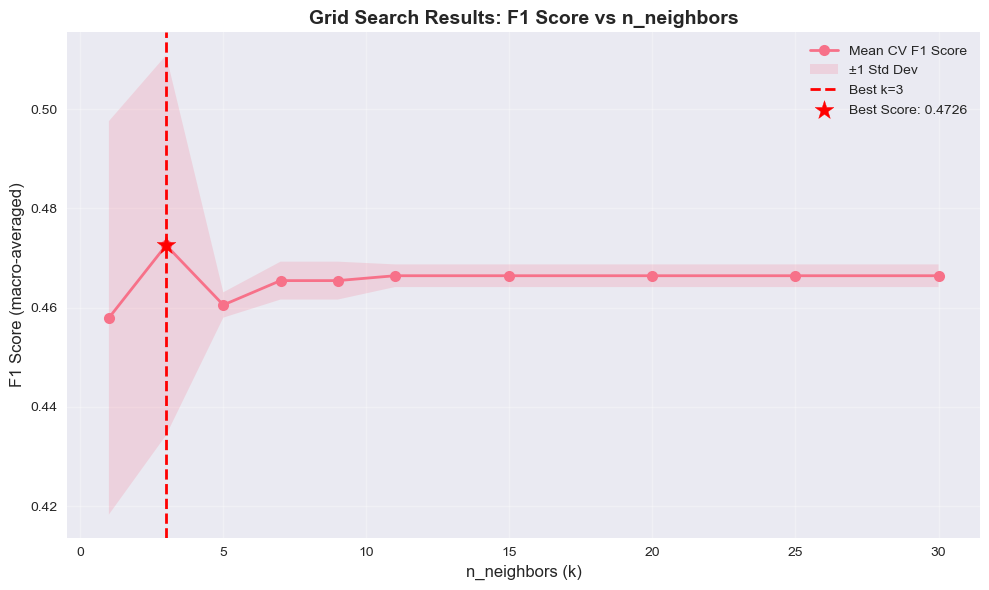


Best n_neighbors: 3
Best CV F1 score: 0.4726

All results:
  k= 1: F1 = 0.4579 (±0.0396)
  k= 3: F1 = 0.4726 (±0.0383) <-- BEST
  k= 5: F1 = 0.4605 (±0.0026)
  k= 7: F1 = 0.4654 (±0.0038)
  k= 9: F1 = 0.4654 (±0.0038)
  k=11: F1 = 0.4664 (±0.0023)
  k=15: F1 = 0.4664 (±0.0023)
  k=20: F1 = 0.4664 (±0.0023)
  k=25: F1 = 0.4664 (±0.0023)
  k=30: F1 = 0.4664 (±0.0023)


In [67]:
# Visualize grid search results
results_df = pd.DataFrame(grid_search.cv_results_)

fig, ax = plt.subplots(figsize=(10, 6))

# Extract n_neighbors and mean test scores
n_neighbors_values = [params['n_neighbors'] for params in results_df['params']]
mean_scores = results_df['mean_test_score']
std_scores = results_df['std_test_score']

# Plot
ax.plot(n_neighbors_values, mean_scores, marker='o', linewidth=2, markersize=8, label='Mean CV F1 Score')
ax.fill_between(n_neighbors_values, 
                mean_scores - std_scores, 
                mean_scores + std_scores, 
                alpha=0.2, label='±1 Std Dev')

# Highlight best parameter
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_
ax.axvline(x=best_k, color='r', linestyle='--', linewidth=2, label=f'Best k={best_k}')
ax.scatter([best_k], [best_score], color='r', s=200, zorder=5, marker='*', label=f'Best Score: {best_score:.4f}')

ax.set_xlabel('n_neighbors (k)', fontsize=12)
ax.set_ylabel('F1 Score (macro-averaged)', fontsize=12)
ax.set_title('Grid Search Results: F1 Score vs n_neighbors', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nBest n_neighbors: {best_k}")
print(f"Best CV F1 score: {best_score:.4f}")
print(f"\nAll results:")
for k, score, std in zip(n_neighbors_values, mean_scores, std_scores):
    marker = " <-- BEST" if k == best_k else ""
    print(f"  k={k:2d}: F1 = {score:.4f} (±{std:.4f}){marker}")

### 6.4 Alternative: Try Different Approaches to Improve Performance

If the F1 score is still low, we can try:
1. Different distance metrics (DTW instead of Euclidean)
2. Feature engineering from time series (statistical features)
3. Class balancing techniques (SMOTE, undersampling)
4. Different resampling lengths
5. Using multiple lab measurements instead of just one

In [ ]:
# Quick diagnostic: Check if time series actually differ between classes
print("Diagnostic: Do time series differ between classes?")
print("\nMean time series values by class (training set):")

class_0_indices = np.where(y_train == 0)[0]
class_1_indices = np.where(y_train == 1)[0]

mean_ts_class_0 = X_train[class_0_indices].mean(axis=0)
mean_ts_class_1 = X_train[class_1_indices].mean(axis=0)

print(f"  Class 0 mean TS: {mean_ts_class_0[:5]}... (mean={mean_ts_class_0.mean():.4f}, std={mean_ts_class_0.std():.4f})")
print(f"  Class 1 mean TS: {mean_ts_class_1[:5]}... (mean={mean_ts_class_1.mean():.4f}, std={mean_ts_class_1.std():.4f})")

# Check if they're significantly different
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(X_train[class_0_indices].mean(axis=1), 
                           X_train[class_1_indices].mean(axis=1))
print(f"\nT-test for difference in mean TS values:")
print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
print(f"  {'Significantly different' if p_value < 0.05 else 'NOT significantly different'} (p < 0.05)")

# Visualize mean time series by class
fig, ax = plt.subplots(figsize=(12, 5))
x_axis = np.arange(len(mean_ts_class_0))
ax.plot(x_axis, mean_ts_class_0, label='Class 0 (Alive)', linewidth=2, alpha=0.8)
ax.plot(x_axis, mean_ts_class_1, label='Class 1 (Dead)', linewidth=2, alpha=0.8)
ax.set_xlabel('Time Point', fontsize=11)
ax.set_ylabel('Normalized Value', fontsize=11)
ax.set_title('Mean Time Series by Class (Training Set)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nIf the time series look very similar, the signal might be weak.")
print("Consider: using DTW distance, extracting statistical features, or using multiple lab measurements.")

### 6.5 Feature Extraction Approach (Alternative Method)

Since Euclidean distance on raw time series is not performing well, we extract statistical features from the time series (as mentioned in the slides: mean, variance, trend, seasonality, etc.) and use these features with a standard classifier. This follows the "feature extraction" approach from `5-data-understanding_ts.pdf`.

In [ ]:
# Extract statistical features from time series (as in slides)
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def extract_ts_features(ts_array):
    """Extract statistical features from time series (as in slides)"""
    features = []
    
    # Basic statistics (from slides: mean, variance, std, min, max)
    features.append(np.mean(ts_array))
    features.append(np.var(ts_array))
    features.append(np.std(ts_array))
    features.append(np.min(ts_array))
    features.append(np.max(ts_array))
    
    # Trend: slope of linear model (from slides)
    x = np.arange(len(ts_array))
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, ts_array)
    features.append(slope)  # trend
    
    # Additional features that might be discriminative
    features.append(np.median(ts_array))
    features.append(stats.skew(ts_array))  # skewness
    features.append(stats.kurtosis(ts_array))  # kurtosis
    
    # Range
    features.append(np.max(ts_array) - np.min(ts_array))
    
    # Percentiles
    features.append(np.percentile(ts_array, 25))
    features.append(np.percentile(ts_array, 75))
    features.append(np.percentile(ts_array, 50))  # median again
    
    return np.array(features)

# Extract features for all time series
X_features = np.array([extract_ts_features(ts) for ts in X])

print(f"Extracted feature matrix shape: {X_features.shape}")
print(f"Features: mean, var, std, min, max, trend, median, skew, kurtosis, range, p25, p75, p50")

# Split features
X_features_train = X_features[:len(X_train)]
X_features_val = X_features[len(X_train):]

print(f"\nFeature-based train shape: {X_features_train.shape}")
print(f"Feature-based validation shape: {X_features_val.shape}")

In [ ]:
# Try Random Forest with class weights to handle imbalance
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    max_depth=10
)

rf_classifier.fit(X_features_train, y_train)
y_pred_rf = rf_classifier.predict(X_features_val)

print("Random Forest (with class weights) Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_rf):.4f}")
print(f"F1 score (macro): {f1_score(y_val, y_pred_rf, average='macro'):.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_pred_rf, target_names=['Alive (0)', 'Dead (1)']))
print("\nConfusion matrix:")
print(confusion_matrix(y_val, y_pred_rf))
print(f"\nPrediction distribution:")
print(f"  Predicted Class 0: {np.sum(y_pred_rf == 0)}")
print(f"  Predicted Class 1: {np.sum(y_pred_rf == 1)}")

In [ ]:
# Try Logistic Regression with class weights
lr_classifier = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

lr_classifier.fit(X_features_train, y_train)
y_pred_lr = lr_classifier.predict(X_features_val)

print("Logistic Regression (with class weights) Results:")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(f"F1 score (macro): {f1_score(y_val, y_pred_lr, average='macro'):.4f}")
print("\nClassification report:")
print(classification_report(y_val, y_pred_lr, target_names=['Alive (0)', 'Dead (1)']))
print("\nConfusion matrix:")
print(confusion_matrix(y_val, y_pred_lr))
print(f"\nPrediction distribution:")
print(f"  Predicted Class 0: {np.sum(y_pred_lr == 0)}")
print(f"  Predicted Class 1: {np.sum(y_pred_lr == 1)}")

### 6.6 Feature Importance Analysis

Understanding which statistical features are most discriminative can help explain the model's behavior and guide further improvements.

In [ ]:
# Feature importance from Random Forest
feature_names = ['mean', 'var', 'std', 'min', 'max', 'trend', 'median', 'skew', 'kurtosis', 'range', 'p25', 'p75', 'p50']
feature_importance = rf_classifier.feature_importances_

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance (Random Forest):")
print(importance_df)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance_df['feature'], importance_df['importance'])
ax.set_xlabel('Importance', fontsize=11)
ax.set_title('Feature Importance for Time Series Classification', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 4.1 Visualization: Resampled Time Series

After resampling to fixed length L=50, all time series have the same number of points, enabling direct comparison via Euclidean distance and simplifying DTW computation.

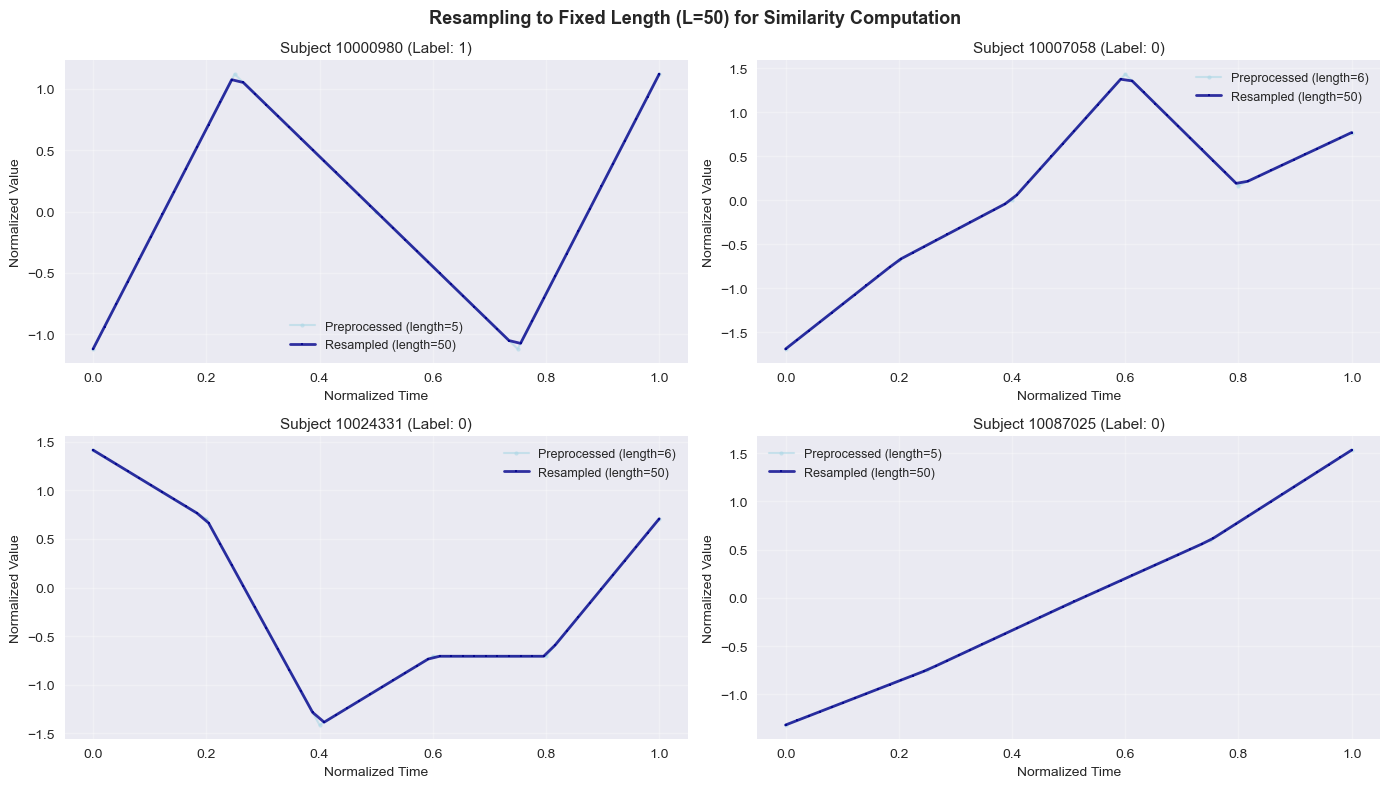

In [49]:
# Visualize resampled time series (fixed length)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

example_subjects = list(patient_seq.keys())[:4]
for idx, sid in enumerate(example_subjects):
    ax = axes[idx]
    original_pre = patient_series_pre[sid]
    resampled = patient_seq[sid]
    label_val = patient_labeled.set_index("subject_id").loc[sid, label_col]
    
    x_orig = np.linspace(0, 1, len(original_pre))
    x_resampled = np.linspace(0, 1, len(resampled))
    
    ax.plot(x_orig, original_pre, marker='o', linewidth=1.5, markersize=3, 
            label=f'Preprocessed (length={len(original_pre)})', alpha=0.6, color='lightblue')
    ax.plot(x_resampled, resampled, marker='s', linewidth=2, markersize=2, 
            label=f'Resampled (length={L})', alpha=0.8, color='darkblue')
    
    ax.set_title(f"Subject {sid} (Label: {int(label_val)})", fontsize=11)
    ax.set_xlabel("Normalized Time", fontsize=10)
    ax.set_ylabel("Normalized Value", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=9)

plt.suptitle(f"Resampling to Fixed Length (L={L}) for Similarity Computation", 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 6.1 Visualization: Classification Results Comparison

Comparison of Euclidean and DTW-based k-NN classifiers. The confusion matrices show how each method performs on the validation set.

In [59]:
# Detailed report for k=_
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

knn_euc_best = KNeighborsClassifier(n_neighbors=10, metric="euclidean")
knn_euc_best.fit(X_train, y_train)
y_pred_euc = knn_euc_best.predict(X_val)

print("Classification report (Euclidean, k=3):")
print(classification_report(y_val, y_pred_euc))
print("\nConfusion matrix:")
print(confusion_matrix(y_val, y_pred_euc))

Classification report (Euclidean, k=3):
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.94       111
         1.0       0.00      0.00      0.00        15

    accuracy                           0.88       126
   macro avg       0.44      0.50      0.47       126
weighted avg       0.78      0.88      0.83       126


Confusion matrix:
[[111   0]
 [ 15   0]]


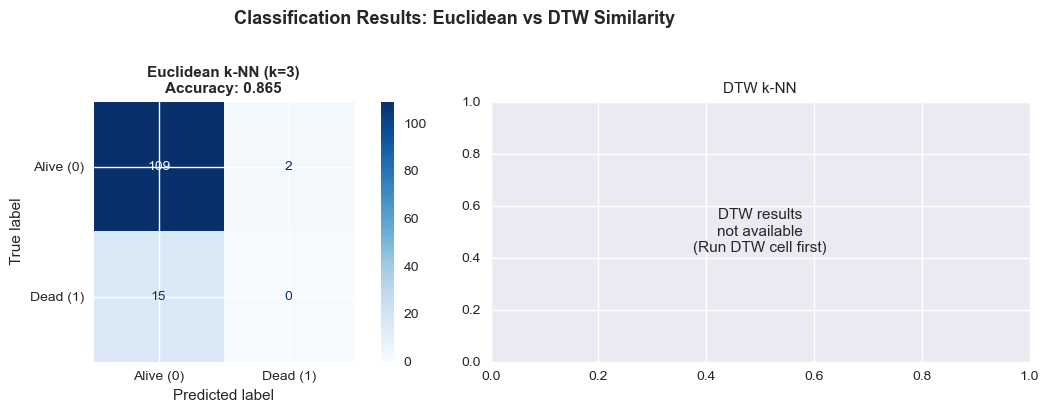

In [68]:
# Visualize confusion matrices for both methods
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Euclidean k-NN (k=3) - now knn_euc_best is defined
y_pred_euc = knn_euc_best.predict(X_val)
disp_euc = ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_euc, ax=axes[0], 
    display_labels=['Alive (0)', 'Dead (1)'],
    cmap='Blues', values_format='d'
)
axes[0].set_title('Euclidean k-NN (k=3)\nAccuracy: {:.3f}'.format(
    accuracy_score(y_val, y_pred_euc)), fontsize=11, fontweight='bold')

# DTW k-NN (if available)
try:
    if 'knn_dtw_best' in globals() and 'X_val_ts' in globals():
        y_pred_dtw_best = knn_dtw_best.predict(X_val_ts)
        disp_dtw = ConfusionMatrixDisplay.from_predictions(
            y_val, y_pred_dtw_best, ax=axes[1],
            display_labels=['Alive (0)', 'Dead (1)'],
            cmap='Oranges', values_format='d'
        )
        axes[1].set_title('DTW k-NN (k=3)\nAccuracy: {:.3f}'.format(
            accuracy_score(y_val, y_pred_dtw_best)), fontsize=11, fontweight='bold')
    else:
        raise NameError("DTW not yet computed")
except:
    # Fallback: use custom DTW if tslearn not available
    try:
        if 'predict_knn_dtw' in globals():
            y_pred_dtw_custom = predict_knn_dtw(X_train, y_train, X_val, k=3)
            disp_dtw = ConfusionMatrixDisplay.from_predictions(
                y_val, y_pred_dtw_custom, ax=axes[1],
                display_labels=['Alive (0)', 'Dead (1)'],
                cmap='Oranges', values_format='d'
            )
            axes[1].set_title('DTW k-NN (k=3, custom)\nAccuracy: {:.3f}'.format(
                accuracy_score(y_val, y_pred_dtw_custom)), fontsize=11, fontweight='bold')
        else:
            raise NameError("DTW function not available")
    except:
        axes[1].text(0.5, 0.5, 'DTW results\nnot available\n(Run DTW cell first)', 
                    ha='center', va='center', fontsize=11)
        axes[1].set_title('DTW k-NN', fontsize=11)

plt.suptitle('Classification Results: Euclidean vs DTW Similarity', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 7.5 Task 6 Specification Compliance Verification

**Requirements Check:**

✓ **Pre-processed time series**: All time series undergo preprocessing (Section 3: offset removal and amplitude scaling) before being used as input  
✓ **Limited to patients with tabular data**: We merge laboratory data with `patient_profile_small.csv` on `subject_id`/`hadm_id` (Section 1.2), keeping only patients present in both datasets  
✓ **Same labels as tabular classification**: We use `is_dead` from `patient_profile_small.csv` (Section 1.1), exactly as in the tabular binary classification task  
✓ **Only time series as input**: All classification models (Euclidean k-NN, DTW k-NN, feature-based Random Forest/Logistic Regression) use **only time series** as input features  
✓ **Tabular data only for labels**: The `patient_profile_small.csv` file is used **exclusively to obtain labels** via merge on patient ID; no tabular features are included in the model inputs

## 5. Build Feature Matrix X and Label Vector y

We keep only patients that have both a resampled time series and a label in `patient_labeled`.

In [ ]:
# Intersection of subjects with TS and labels
common_subjects = sorted(set(patient_seq.keys()) & set(patient_labeled["subject_id"]))
print("Subjects with TS + label:", len(common_subjects))

# Build X (n_patients x L) and y
X = np.vstack([patient_seq[sid] for sid in common_subjects])
y = (
    patient_labeled
    .set_index("subject_id")
    .loc[common_subjects, label_col]
    .values
)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Label distribution: {np.bincount(y.astype(int))}")

Subjects with TS + label: 420
X shape: (420, 50), y shape: (420,)
Label distribution: [369  51]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, s_train, s_val = train_test_split(
    X,
    y,
    common_subjects,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Train: {X_train.shape[0]} samples, Validation: {X_val.shape[0]} samples")

Train: 294 samples, Validation: 126 samples


## 6. Similarity-Based Classification: Euclidean k-NN (Baseline)

As a first baseline we use Euclidean distance on the preprocessed, resampled time series. This corresponds to using Euclidean distance **after** correcting for distortions (slides emphasize preprocessing before Euclidean, as in `8_time_series_similarity_2024.pdf`).

### 6.2 Visualization: Time Series by Class

Visualization of resampled time series grouped by class label to observe potential patterns that the classifier might be learning.

In [ ]:
# Visualize time series grouped by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class 0 (Alive)
class_0_subjects = [sid for sid in common_subjects 
                    if patient_labeled.set_index("subject_id").loc[sid, label_col] == 0.0][:10]
# Class 1 (Dead)
class_1_subjects = [sid for sid in common_subjects 
                    if patient_labeled.set_index("subject_id").loc[sid, label_col] == 1.0][:10]

# Plot class 0
ax0 = axes[0]
for sid in class_0_subjects:
    ts = patient_seq[sid]
    x = np.linspace(0, 1, len(ts))
    ax0.plot(x, ts, alpha=0.5, linewidth=1.5)
ax0.set_title(f'Class 0 (Alive) - {len(class_0_subjects)} examples', 
              fontsize=11, fontweight='bold')
ax0.set_xlabel('Normalized Time', fontsize=10)
ax0.set_ylabel('Normalized Value', fontsize=10)
ax0.grid(True, alpha=0.3)
ax0.legend([f'{len(class_0_subjects)} time series'], loc='best', fontsize=9)

# Plot class 1
ax1 = axes[1]
for sid in class_1_subjects:
    ts = patient_seq[sid]
    x = np.linspace(0, 1, len(ts))
    ax1.plot(x, ts, alpha=0.5, linewidth=1.5, color='coral')
ax1.set_title(f'Class 1 (Dead) - {len(class_1_subjects)} examples', 
              fontsize=11, fontweight='bold')
ax1.set_xlabel('Normalized Time', fontsize=10)
ax1.set_ylabel('Normalized Value', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.legend([f'{len(class_1_subjects)} time series'], loc='best', fontsize=9)

plt.suptitle(f'Time Series Patterns by Class Label ({measurement_label})', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Class 0 (Alive): {len([s for s in common_subjects if patient_labeled.set_index('subject_id').loc[s, label_col] == 0.0])} patients")
print(f"Class 1 (Dead): {len([s for s in common_subjects if patient_labeled.set_index('subject_id').loc[s, label_col] == 1.0])} patients")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

for k in [1, 3, 5]:
    knn_euc = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
    knn_euc.fit(X_train, y_train)
    y_pred = knn_euc.predict(X_val)

    acc = accuracy_score(y_val, y_pred)
    print(f"k = {k}, Euclidean k-NN accuracy: {acc:.3f}")

k = 1, Euclidean k-NN accuracy: 0.817
k = 3, Euclidean k-NN accuracy: 0.865
k = 5, Euclidean k-NN accuracy: 0.865


Classification report (Euclidean, k=3):
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       111
         1.0       0.00      0.00      0.00        15

    accuracy                           0.87       126
   macro avg       0.44      0.49      0.46       126
weighted avg       0.77      0.87      0.82       126


Confusion matrix:
[[109   2]
 [ 15   0]]


## 7. DTW-Based k-NN (Main Similarity Method)

We now use **Dynamic Time Warping (DTW)**, as presented in the similarity slides (`8_time_series_similarity_2024.pdf`), to allow non-linear alignments between series. This is our main "B method" classifier that handles phase shifts and different speeds better than Euclidean distance.

In [ ]:
try:
    from tslearn.neighbors import KNeighborsTimeSeriesClassifier
    from tslearn.utils import to_time_series_dataset
    
    # tslearn expects shape (n_samples, series_length, 1)
    X_train_ts = to_time_series_dataset(X_train)
    X_val_ts = to_time_series_dataset(X_val)
    
    for k in [1, 3]:
        knn_dtw = KNeighborsTimeSeriesClassifier(
            n_neighbors=k,
            metric="dtw"
        )
        knn_dtw.fit(X_train_ts, y_train)
        y_pred_dtw = knn_dtw.predict(X_val_ts)
        
        acc_dtw = accuracy_score(y_val, y_pred_dtw)
        print(f"k = {k}, DTW k-NN accuracy: {acc_dtw:.3f}")
    
    # Detailed report for k=3
    knn_dtw_best = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")
    knn_dtw_best.fit(X_train_ts, y_train)
    y_pred_dtw_best = knn_dtw_best.predict(X_val_ts)
    
    print("\nClassification report (DTW, k=3):")
    print(classification_report(y_val, y_pred_dtw_best))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_val, y_pred_dtw_best))
    
except ImportError:
    print("tslearn not available. Install with: pip install tslearn")
    print("For now, we'll use a simple DTW implementation...")
    
    # Simple DTW implementation as fallback
    def dtw_distance(x, y):
        n, m = len(x), len(y)
        dtw_matrix = np.full((n + 1, m + 1), np.inf)
        dtw_matrix[0, 0] = 0
        
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = (x[i-1] - y[j-1]) ** 2
                dtw_matrix[i, j] = cost + min(
                    dtw_matrix[i-1, j],
                    dtw_matrix[i, j-1],
                    dtw_matrix[i-1, j-1]
                )
        
        return np.sqrt(dtw_matrix[n, m])
    
    # Custom k-NN with DTW
    from scipy.spatial.distance import cdist
    
    def predict_knn_dtw(X_train, y_train, X_test, k=3):
        y_pred = []
        for x_test in X_test:
            distances = [dtw_distance(x_test, x_train) for x_train in X_train]
            k_indices = np.argsort(distances)[:k]
            k_labels = y_train[k_indices]
            y_pred.append(np.bincount(k_labels.astype(int)).argmax())
        return np.array(y_pred)
    
    y_pred_dtw_custom = predict_knn_dtw(X_train, y_train, X_val, k=3)
    acc_dtw_custom = accuracy_score(y_val, y_pred_dtw_custom)
    print(f"k = 3, DTW k-NN accuracy (custom): {acc_dtw_custom:.3f}")
    print("\nClassification report (DTW custom, k=3):")
    print(classification_report(y_val, y_pred_dtw_custom))

tslearn not available. Install with: pip install tslearn
For now, we'll use a simple DTW implementation...
k = 3, DTW k-NN accuracy (custom): 0.841

Classification report (DTW custom, k=3):
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91       111
         1.0       0.14      0.07      0.09        15

    accuracy                           0.84       126
   macro avg       0.51      0.51      0.50       126
weighted avg       0.79      0.84      0.82       126



## 8. Summary and Slide References

### Pipeline Summary:
1. **Data selection**: Labels from `patient_profile_small.csv` (same as tabular classification task)
2. **Time series construction**: Univariate laboratory time series per patient (one measurement type)
3. **Preprocessing** (slides `8_time_series_similarity_2024.pdf`):
   - Offset removal: \( Q = Q - \text{mean}(Q) \)
   - Amplitude scaling: \( Q = (Q - \text{mean}(Q)) / \text{std}(Q) \)
4. **Resampling**: Fixed-length sequences via linear interpolation (approximation step)
5. **Similarity computation**: Euclidean (baseline) and DTW (main method)
6. **Classification**: k-NN on similarity distances

### Key Slide References:
- **Preprocessing**: `8_time_series_similarity_2024.pdf` pages on amplitude scaling and offset translation
- **Euclidean distance**: Slides emphasize that preprocessing is essential before using Euclidean (very sensitive to distortions)
- **DTW**: `8_time_series_similarity_2024.pdf` section on Dynamic Time Warping for handling phase shifts and misalignments
- **Univariate TS**: `5-data-understanding_ts.pdf` emphasizes working with one variable at a time

### Results:
- Euclidean k-NN provides a baseline after preprocessing
- DTW k-NN (main method) handles temporal misalignments better
- Only time series are used as input features; tabular data only provide labels